In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as back
from fitter import Fitter, get_common_distributions, get_distributions

2024-04-22 17:45:58.758907: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-22 17:45:58.759319: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-22 17:45:58.761369: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-22 17:45:58.787438: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 17:45:59.298114: W tensorflow/compiler/tf2tensorrt/utils/py_uti

First, the cleaned data is read in from the csv.

In [3]:
ang = pd.read_csv('full_data.csv', usecols=['Ang_Pos'])
gaze = pd.read_csv('full_data.csv', usecols=['Gaze.x.', 'Gaze.y.'])

Then, the data is randomly split into train/test portions, normalized, and converted to a format that can be input to keras.

In [4]:
ang_train, ang_test, gaze_train, gaze_test = train_test_split(ang, gaze, test_size=0.33)

ang_train = (ang_train + 360) / 360
ang_test = (ang_test + 360) / 360

ang_train = ang_train.astype(np.float32).to_numpy()
ang_test = ang_test.astype(np.float32).to_numpy()

gaze_train['Gaze.x.'] = gaze_train['Gaze.x.'] / 2560
gaze_train['Gaze.y.'] = gaze_train['Gaze.y.'] / 1080

gaze_test['Gaze.x.'] = gaze_test['Gaze.x.'] / 2560
gaze_test['Gaze.y.'] = gaze_test['Gaze.y.'] / 1080

gaze_train = gaze_train.astype(np.float32).to_numpy()
gaze_test = gaze_test.astype(np.float32).to_numpy()

In [5]:
ang_train.min(), ang_train.max()

(0.38541603, 1.5667822)

In [6]:
gaze_test

array([[0.5289969 , 0.3598801 ],
       [0.47193593, 0.35346666],
       [0.76614296, 0.4317275 ],
       ...,
       [0.6427109 , 0.46131232],
       [0.7244324 , 0.38068426],
       [1.1174258 , 0.45808214]], dtype=float32)

The model has four fully connected RELU layers, which was able to achieve reasonable accuracy without running extremely slowly. The output layer is also RELU, since sigmoid only returns values (0, 1) and softmax isn't applicable to 1-dim arrays.

Adam is a widely useful optimizer and mean_absolute_percentage_error was the most effective with our non-categorical data.

In [6]:
model = keras.Sequential([
    keras.layers.Input((2,)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(64, activation='relu'),
    
    keras.layers.Dense(1, activation='relu')
])

# Compile 
model.compile(optimizer='adam', loss='mean_absolute_percentage_error', metrics=[keras.metrics.MeanAbsolutePercentageError()])

# Train
h = model.fit(gaze_train, ang_train, epochs=50, validation_split=0.1)


Epoch 1/50


2024-04-22 17:46:09.098954: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-04-22 17:46:09.098983: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: ajs-laptop
2024-04-22 17:46:09.098990: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: ajs-laptop
2024-04-22 17:46:09.099164: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 535.171.4
2024-04-22 17:46:09.099185: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 535.171.4
2024-04-22 17:46:09.099189: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:248] kernel version seems to match DSO: 535.171.4


4092/4092 ━━━━━━━━━━━━━━━━━━━━ 3s 496us/step - loss: 29.1188 - mean_absolute_percentage_error: 29.1188 - val_loss: 21.1173 - val_mean_absolute_percentage_error: 21.1152
Epoch 2/50
4092/4092 ━━━━━━━━━━━━━━━━━━━━ 2s 486us/step - loss: 22.0338 - mean_absolute_percentage_error: 22.0338 - val_loss: 21.2303 - val_mean_absolute_percentage_error: 21.2279
Epoch 3/50
4092/4092 ━━━━━━━━━━━━━━━━━━━━ 2s 490us/step - loss: 21.7244 - mean_absolute_percentage_error: 21.7244 - val_loss: 21.3177 - val_mean_absolute_percentage_error: 21.3164
Epoch 4/50
4092/4092 ━━━━━━━━━━━━━━━━━━━━ 2s 452us/step - loss: 21.5765 - mean_absolute_percentage_error: 21.5765 - val_loss: 20.9834 - val_mean_absolute_percentage_error: 20.9824
Epoch 5/50
4092/4092 ━━━━━━━━━━━━━━━━━━━━ 2s 430us/step - loss: 21.5041 - mean_absolute_percentage_error: 21.5041 - val_loss: 20.9592 - val_mean_absolute_percentage_error: 20.9581
Epoch 6/50
4092/4092 ━━━━━━━━━━━━━━━━━━━━ 2s 437us/step - loss: 21.3820 - mean_absolute_percentage_error: 21.38

4092/4092 ━━━━━━━━━━━━━━━━━━━━ 2s 461us/step - loss: 20.5785 - mean_absolute_percentage_error: 20.5785 - val_loss: 19.9928 - val_mean_absolute_percentage_error: 19.9899
Epoch 40/50
4092/4092 ━━━━━━━━━━━━━━━━━━━━ 2s 478us/step - loss: 20.5485 - mean_absolute_percentage_error: 20.5485 - val_loss: 20.4253 - val_mean_absolute_percentage_error: 20.4233
Epoch 41/50
4092/4092 ━━━━━━━━━━━━━━━━━━━━ 2s 453us/step - loss: 20.5303 - mean_absolute_percentage_error: 20.5303 - val_loss: 19.9982 - val_mean_absolute_percentage_error: 19.9960
Epoch 42/50
4092/4092 ━━━━━━━━━━━━━━━━━━━━ 2s 465us/step - loss: 20.5593 - mean_absolute_percentage_error: 20.5593 - val_loss: 20.0040 - val_mean_absolute_percentage_error: 20.0032
Epoch 43/50
4092/4092 ━━━━━━━━━━━━━━━━━━━━ 2s 448us/step - loss: 20.5217 - mean_absolute_percentage_error: 20.5217 - val_loss: 19.8021 - val_mean_absolute_percentage_error: 19.7989
Epoch 44/50
4092/4092 ━━━━━━━━━━━━━━━━━━━━ 2s 460us/step - loss: 20.5091 - mean_absolute_percentage_error: 

The model starts at a surprisingly low error rate, leaving not much room for growth without overfitting. However, we trained the model to ~80% accuracy.

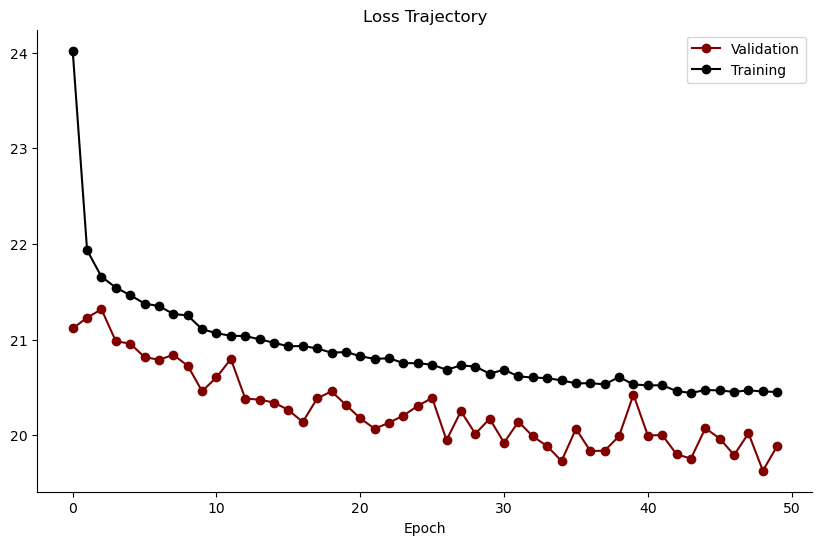

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(range(50), h.history['val_loss'], 'o-', color='maroon', label='Validation')
ax.plot(range(50), h.history['loss'], 'o-', color='black', label='Training')
ax.set_xlabel('Epoch')
#ax.set_ylabel('Huber loss')
ax.legend()
ax.set_title('Loss Trajectory')
sns.despine(ax=ax)

In [8]:
test_loss, test_accuracy = model.evaluate(gaze_test, ang_test)

2240/2240 ━━━━━━━━━━━━━━━━━━━━ 1s 354us/step - loss: 20.1179 - mean_absolute_percentage_error: 20.1179


In [9]:
test_loss, test_accuracy

(20.215404510498047, 20.20917320251465)

In the interest of using this data to inform our likelihood, sample predictions were used to generate a distribution of possible "headings" (relative angular positions).

In [10]:
pred = model.predict(gaze_test)
pred = (pred * 360) - 360

2240/2240 ━━━━━━━━━━━━━━━━━━━━ 1s 399us/step


In [12]:
pred

array([[ 11.683014],
       [-95.30231 ],
       [-11.636749],
       ...,
       [-27.855743],
       [ 10.629089],
       [-97.18213 ]], dtype=float32)

The data is plotted to get an idea of the rel-ang-position relative frequencies.

/home/aj/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


(-200.0, 200.0)

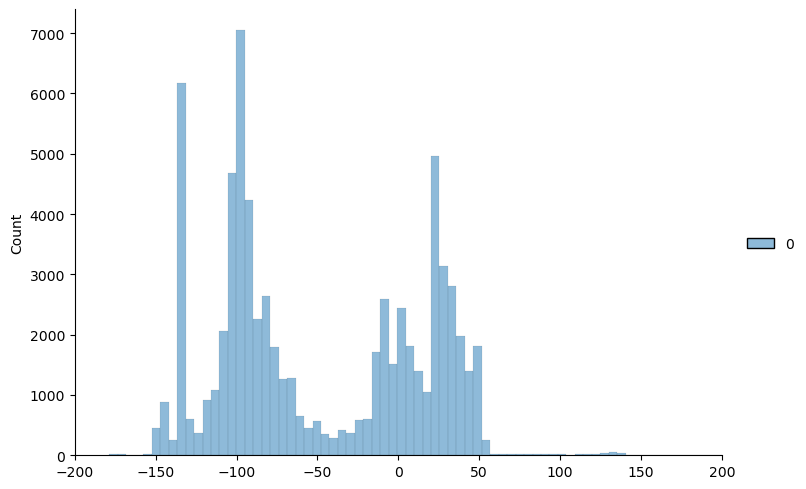

In [23]:
sns.displot(data=pred, kind="hist", bins = 1000, aspect = 1.5)
plt.xlim(left=-200, right=200)

Fitter is used to find the best fit distribution to the output data.

In [24]:
f = Fitter(pred)
f.fit()

2024-04-22 17:11:59.803 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED _fit distribution (taking more than 30 seconds)
2024-04-22 17:12:00.159 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=3.4e-05)
2024-04-22 17:12:00.356 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted arcsine distribution with error=8.4e-05)
2024-04-22 17:12:00.431 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted anglit distribution with error=4.2e-05)
2024-04-22 17:12:00.640 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted bradford distribution with error=8.8e-05)
2024-04-22 17:12:00.661 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted alpha distribution with error=8.8e-05)
2024-04-22 17:12:00.713 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=2.9e-05)
2024-04-22 17:12:00.733 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted

2024-04-22 17:12:50.815 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted halfgennorm distribution with error=6.2e-05)
2024-04-22 17:12:50.868 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED kstwo distribution (taking more than 30 seconds)
2024-04-22 17:12:50.911 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted halflogistic distribution with error=3.4e-05)
2024-04-22 17:12:50.990 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted laplace distribution with error=3.3e-05)
2024-04-22 17:12:52.605 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted invweibull distribution with error=7.5e-05)
2024-04-22 17:12:53.002 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted kstwobign distribution with error=2.7e-05)
2024-04-22 17:12:53.424 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted laplace_asymmetric distribution with error=3.6e-05)
2024-04-22 17:12:55.456 | INFO     | fitter.fitter:_fit_

2024-04-22 17:13:50.397 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED powerlognorm distribution (taking more than 30 seconds)
2024-04-22 17:13:53.045 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED powernorm distribution (taking more than 30 seconds)
/home/aj/anaconda3/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
2024-04-22 17:13:56.480 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED rdist distribution (taking more than 30 seconds)
2024-04-22 17:13:56.940 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED recipinvgauss distribution (taking more than 30 seconds)
2024-04-22 17:13:58.130 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted semicircular distribution with error=5e-05)
2024-04-22 17:13:59.392 | WARNING  | fitter.fitter:_fit_s

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
dweibull,0.000003,250713.549913,250741.088725,inf,0.115036,0.0
dgamma,0.000009,35598.847082,35626.385895,inf,0.116254,0.0
rayleigh,0.000023,86709.235771,86727.594980,inf,0.124579,0.0
nakagami,0.000025,98796.437623,98823.976436,inf,0.124592,0.0
invgauss,0.000026,9835.004954,9862.543767,inf,0.152397,0.0


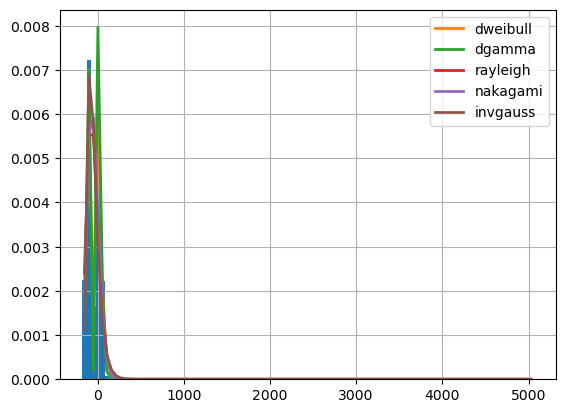

In [25]:
f.summary()

The best fitting distribution for heading is dweibull.

I was curious to see what it might look like to plot "heading" against Gaze(x), and the answer is a hedgehog.

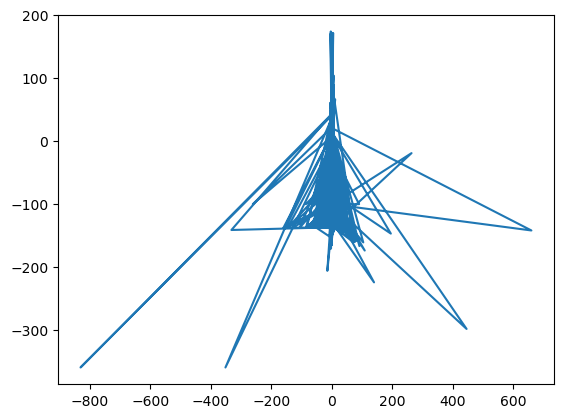

In [14]:
plt.plot(gaze_test[:,0], pred[:,0])

In [57]:
#np.array((gaze_test[:,0], pred))
np.array(gaze_test[:,0], pred[:,0])

TypeError: Cannot construct a dtype from an array

We also attempted to train a model to predict heading based on gaze, but this was not effective.

In [45]:
# Basic feedforward structure
model2 = keras.Sequential([
    keras.layers.Input((1,)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    
    keras.layers.Dense(2, activation='sigmoid')
])

# Compile 
model2.compile(optimizer='adam', loss='mean_absolute_percentage_error', metrics=[keras.metrics.MeanAbsolutePercentageError()])

# Train
j = model2.fit(ang_train, gaze_train, epochs=20, validation_split=0.1)


Epoch 1/20


KeyboardInterrupt: 

NameError: name 'j' is not defined

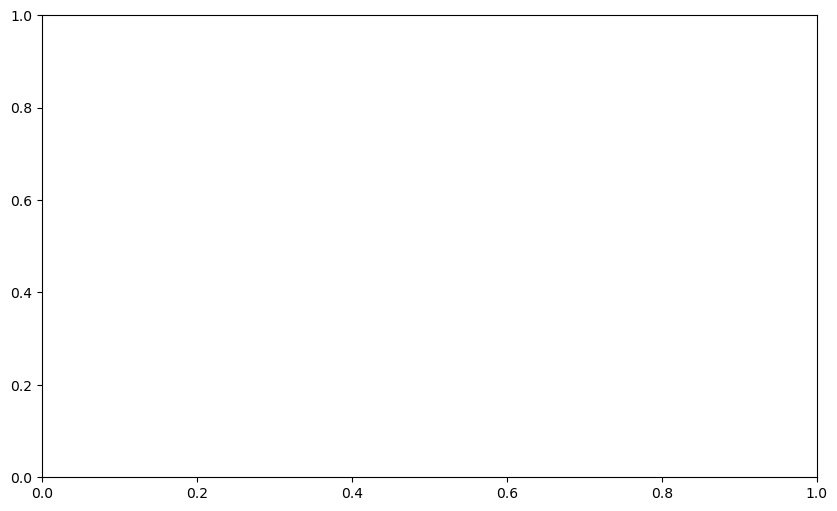

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(range(50), j.history['val_loss'], 'o-', color='maroon', label='Validation')
ax.plot(range(50), j.history['loss'], 'o-', color='black', label='Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('Percentage error')
ax.legend()
ax.set_title('Loss Trajectory')
sns.despine(ax=ax)

In [136]:
test_loss, test_accuracy = model2.evaluate(ang_test, gaze_test)

2240/2240 ━━━━━━━━━━━━━━━━━━━━ 2s 688us/step - loss: 82.0181 - mean_absolute_percentage_error: 82.0181


In [137]:
test_loss, test_accuracy

(75.42182922363281, 75.44270324707031)